# Unsupervised Capstone

An approach to evaluating user preferences in movie genres using clustering techniques.

In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans



In [4]:
ratings = pd.read_csv('ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print('There are {} total entries in the dataset, with {} unique users and {} unique movies.'.format(len(ratings['userId']),ratings['userId'].nunique(),ratings['movieId'].nunique()))


There are 100836 total entries in the dataset, with 610 unique users and 9724 unique movies.


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


All columns are of the expected type and there doesn't appear to be any missing values.

In [7]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

There doesn't appear to be any unexpected ratings value, with 10 different scores ranging from 0.5 to 5. 

In [8]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The movies dataframe shows the title of each movie and which genre they are in.

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [10]:
#Merging the movie and ratings dataset
movieratings_df = pd.merge(movies,ratings,on='movieId')

In [11]:
movieratings_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


Merging the two dataframes we now have a single dataframe with all information contained. The dataframe has each movieId starting from 1 and each user rating and their corresponding ID. The genre and title information for the movie is also contained.

In [12]:
movieratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
movieId      100836 non-null int64
title        100836 non-null object
genres       100836 non-null object
userId       100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


Let's explore the data to see the average movie rating by movie.

In [13]:
movieratings_df['genres'].value_counts()

Comedy                                                            7196
Drama                                                             6291
Comedy|Romance                                                    3967
Comedy|Drama|Romance                                              3000
Comedy|Drama                                                      2851
Drama|Romance                                                     2838
Action|Adventure|Sci-Fi                                           2361
Crime|Drama                                                       2315
Action|Crime|Thriller                                             1554
Action|Adventure|Thriller                                         1455
Action|Adventure|Sci-Fi|Thriller                                  1446
Drama|Thriller                                                    1365
Action|Sci-Fi|Thriller                                            1195
Comedy|Crime                                                      1171
Crime|

There are a lot of different combinations of genres in this dataset. For the purpose of this study we will examine movies that are classified as Comedy, Romance, Horror, or Action movies.

In [14]:
#Create columns for each genre
chosen = ['Comedy','Romance','Horror','Action']
for name in chosen:
    movieratings_df[name] = np.nan

#Label each genre column as 1 if the movie is that genre, otherwise 0
for name in chosen:
    movieratings_df.loc[movieratings_df['genres'].str.contains(name), name] = 1

movieratings_df = movieratings_df.fillna(0)


We have now added 4 columns to our dataframe that represent each genre we are interested in. If the movie is the genre indicated, the column will have a 1 in that spot, otherwise 0.

In [15]:
# Explore the counts of genres in our dataset.
Comedy_mov = 0
Action_mov = 0
Romance_mov = 0
Horror_mov = 0
for movie in movieratings_df['Comedy']:
    if movie == 1:
       Comedy_mov += 1
for movie in movieratings_df['Horror']:
    if movie == 1:
       Horror_mov += 1
for movie in movieratings_df['Action']:
    if movie == 1:
       Action_mov += 1
for movie in movieratings_df['Romance']:
    if movie == 1:
       Romance_mov += 1

print('There are {} Horror, {} Action, {} Romance, and {} Comedy movies in our dataset.'.format(Horror_mov,Action_mov,Romance_mov,Comedy_mov))


There are 7291 Horror, 30635 Action, 18124 Romance, and 39053 Comedy movies in our dataset.


In [16]:
# Create a Genre Dataframe that shows Average genre rating for each User
genre_df = pd.DataFrame()

com_movies = movieratings_df[movieratings_df['Comedy']==1]
avg_com_votes_per_user = com_movies[com_movies['movieId'].isin(com_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
genre_df = pd.concat([genre_df,avg_com_votes_per_user],axis=1)
rom_movies = movieratings_df[movieratings_df['Romance']==1]
avg_rom_votes_per_user = rom_movies[rom_movies['movieId'].isin(rom_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
genre_df = pd.concat([genre_df,avg_rom_votes_per_user],axis=1)
act_movies = movieratings_df[movieratings_df['Action']==1]
avg_act_votes_per_user = act_movies[act_movies['movieId'].isin(act_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
genre_df = pd.concat([genre_df,avg_act_votes_per_user],axis=1)
hor_movies = movieratings_df[movieratings_df['Horror']==1]
avg_hor_votes_per_user = hor_movies[hor_movies['movieId'].isin(hor_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
genre_df = pd.concat([genre_df,avg_hor_votes_per_user],axis=1)

genre_df.columns = ['Avg_Comedy','Avg_Romance','Avg_Action','Avg_Horror']
genre_df.index.name = 'UserID'
genre_df.head()

,Avg_Comedy,Avg_Romance,Avg_Action,Avg_Horror
UserID,,,,
1,4.28,4.31,4.32,3.47
2,4.00,4.50,3.95,3.00
3,1.00,0.50,3.57,4.69
4,3.51,3.38,3.32,4.25
5,3.47,3.09,3.11,3.00


In [17]:
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 1 to 610
Data columns (total 4 columns):
Avg_Comedy     609 non-null float64
Avg_Romance    606 non-null float64
Avg_Action     608 non-null float64
Avg_Horror     535 non-null float64
dtypes: float64(4)
memory usage: 23.8 KB


In [18]:
#Missing values can be dropped 
genre_df = genre_df.dropna()

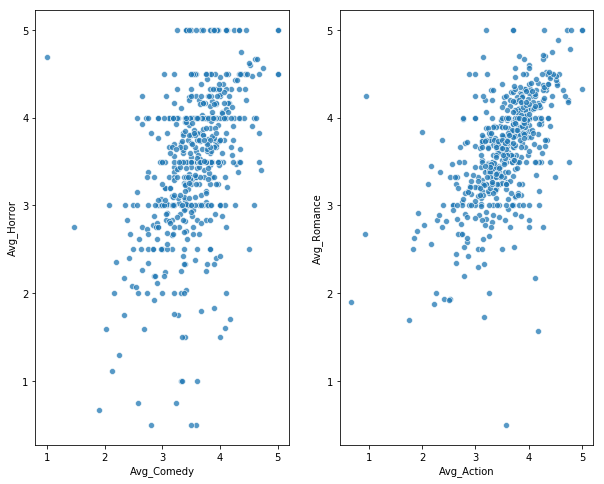

In [19]:
# Let's plot the data to compare users interest in Comedy vs Horror, and Action vs Romance.
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
a = genre_df['Avg_Comedy']
b = genre_df['Avg_Horror']
sns.scatterplot(a,b,alpha=0.75)

plt.subplot(1,2,2)
c = genre_df['Avg_Action']
d = genre_df['Avg_Romance']
sns.scatterplot(c,d,alpha=0.75)
plt.show()

Now let's implement k-means clustering to see if it can be used as a way to interpret user preference.

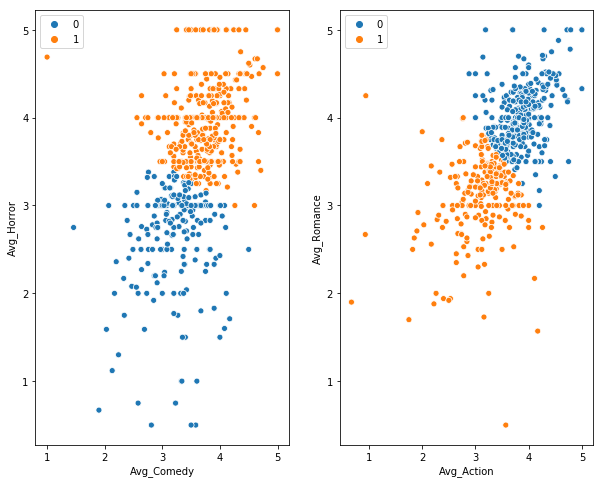

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
X_1 = genre_df[['Avg_Comedy','Avg_Horror']].values
X_2 = genre_df[['Avg_Action','Avg_Romance']].values
# TODO: use fit_predict to cluster the dataset
y_pred = kmeans.fit_predict(X_1)
z_pred = kmeans.fit_predict(X_2)

#Plot the clustered solution using K=2
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.scatterplot(a,b,hue=y_pred)

plt.subplot(1,2,2)
sns.scatterplot(c,d,hue=z_pred)
plt.show()


As you can see there is a clear distinction between the two clusters in our genre plots. The Comedy vs Horror plot shows that the clusters split around where the Avg_Horror rating equals about 3. The Action vs Romance cutoff isn't quite as flat, occuring somewhere between Action equalling 3 to 3.5. But how do we select K?

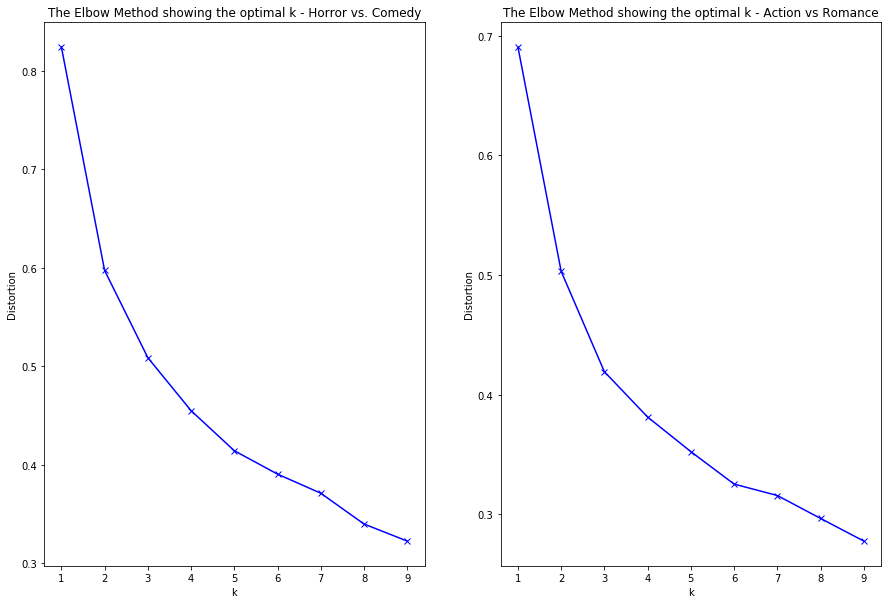

In [25]:
# Selecting k - The Elbow Method
from scipy.spatial.distance import cdist
distortions_1 = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_1)
    kmeanModel.fit(X_1)
    distortions_1.append(sum(np.min(cdist(X_1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_1.shape[0])

distortions_2 = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_2)
    kmeanModel.fit(X_2)
    distortions_2.append(sum(np.min(cdist(X_2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_2.shape[0])
    

# Plot the elbow
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(K, distortions_1, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - Horror vs. Comedy')

plt.subplot(1,2,2)
plt.plot(K, distortions_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - Action vs Romance')
plt.show()

Both the plots above aid us in choosing the optimal k for our k-means algorithms. It appears as if 3 or 4 are reasonable options for the Horror vs Comedy plot, and good choices for the Action vs Romance plot are 3 and 6. Let's try again with the optimal k parameters.

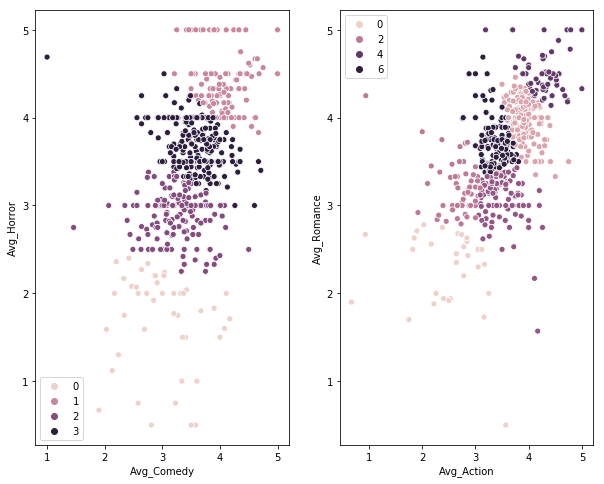

In [27]:
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=4, random_state=0)
kmeans_2 = KMeans(n_clusters=6, random_state=0)

X_1 = genre_df[['Avg_Comedy','Avg_Horror']].values
X_2 = genre_df[['Avg_Action','Avg_Romance']].values
# TODO: use fit_predict to cluster the dataset
y_pred = kmeans_1.fit_predict(X_1)
z_pred = kmeans_2.fit_predict(X_2)

#Plot the clustered solution using K=2
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.scatterplot(a,b,hue=y_pred)

plt.subplot(1,2,2)
sns.scatterplot(c,d,hue=z_pred)
plt.show()

As you can see, the users preferences in each plot seem to become more clear when using the optimal k values. I believe this could be a very successful way in predicting the preferences of specific users and therefore reccomending certain categories to each user. Further research could be used to look at more genres, and using missing values in the data set to predict what a person would rate a specific movie types.